In [ ]:
!pip install librosa

In [ ]:
!pip install python_speech_features

In [ ]:
!pip install speechpy

In [ ]:
!pip install tabulate

In [41]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
from python_speech_features import mfcc
from scipy.io import wavfile
import speechpy
from sklearn.model_selection import train_test_split
import pickle
import seaborn as sns
from tabulate import tabulate
from scipy.stats import multivariate_normal

digits= ['0', '1', '2', '3', '4','5','6','7','8','9']
digit_numbers = len(digits)
min_len = 2900
       

In [42]:
class HMM:
    def __init__(self, num_hidden_states):
        self.num_hidden_states = num_hidden_states
        self.rand_state = np.random.RandomState(1)

        self.initial_prob = self._normalize(self.rand_state.rand(self.num_hidden_states, 1))
        self.transition_matrix = self._stochasticize(self.rand_state.rand(self.num_hidden_states, self.num_hidden_states))

        self.mean = None
        self.covariances = None
        self.num_dimensions = None

    def _forward(self, observation_matrix):

        log_likelihood = 0.
        T = observation_matrix.shape[1]
        alpha = np.zeros(observation_matrix.shape)

        for t in range(T):
            if t == 0:
                alpha[:,0] = self.initial_prob[:,0] * observation_matrix[:,0]
            else:
                alpha[:,t] = np.matmul(self.transition_matrix.T,alpha[:,t-1]) * observation_matrix[:,t]
            alpha_sum = np.sum(alpha[:, t])
            alpha[:, t] /= alpha_sum
            log_likelihood += np.log(alpha_sum)

        return log_likelihood, alpha

    def _backward(self, observation_matrix):
        T = observation_matrix.shape[1]
        beta = np.zeros(observation_matrix.shape)

        beta[:, -1] = np.ones(observation_matrix.shape[0])

        for t in range(T - 1)[::-1]:
            beta[:, t] =  np.matmul(self.transition_matrix,(observation_matrix[:,t+1] * beta[:,t+1]))
            beta[:, t] /= np.sum(beta[:, t])

        return beta

    def _state_likelihood(self, obs):
       
        obs = np.atleast_2d(obs)
        B = np.zeros((self.num_hidden_states, obs.shape[1]))
        for s in range(self.num_hidden_states):
            np.random.seed(self.rand_state.randint(1))
            B[s, :] = multivariate_normal.pdf(obs.T,mean =self.mean[:,s],cov = self.covariances[:,:,s])

        return B

    def _normalize(self, x):
        return (x + (x == 0)) / np.sum(x)

    def _stochasticize(self, x):
        return (x + (x == 0)) / np.sum(x, axis=1)

    def _em_init(self, obs):
        if self.num_dimensions is None:
            self.num_dimensions = obs.shape[0]
        if self.mean is None:
            subset = self.rand_state.choice(np.arange(self.num_dimensions), size=self.num_hidden_states, replace=False)
            self.mean = obs[:, subset]
        if self.covariances is None:
            self.covariances = np.zeros((self.num_dimensions, self.num_dimensions, self.num_hidden_states))
            self.covariances += np.diag(np.diag(np.cov(obs)))[:, :, None]

        return self

    def _em_step(self, obs):
        obs = np.atleast_2d(obs)
        T = obs.shape[1]
        B = self._state_likelihood(obs)
        log_likelihood, alpha = self._forward(B)
        beta = self._backward(B)

        xi_sum = np.zeros((self.num_hidden_states, self.num_hidden_states))
        gamma = np.zeros((self.num_hidden_states, T))

        for t in range(T - 1):
            partial_sum = np.matmul(alpha[:,t],(beta[:,t+1].T*B[:,t+1].T))*self.transition_matrix
            xi_sum += self._normalize(partial_sum)
            partial_g = alpha[:,t] * beta[:,t]
            gamma[:, t] = self._normalize(partial_g)
        partial_g = alpha[:,T-1] * beta[:,T-1]
        gamma[:, -1] = self._normalize(partial_g)

        expected_prior = np.reshape(gamma[:, 0],(-1,1))
        expected_transition = self._stochasticize(xi_sum/np.sum(xi_sum,axis=(0,1)))

        expected_covariances = np.zeros((self.num_dimensions, self.num_dimensions, self.num_hidden_states))
        expected_covariances += .01 * np.eye(self.num_dimensions)[:, :, None]

        gamma_state_sum = np.sum(gamma, axis=1)
        gamma_state_sum = gamma_state_sum + (gamma_state_sum == 0)

        expected_mean = np.zeros((self.num_dimensions, self.num_hidden_states))
        for s in range(self.num_hidden_states):
            gamma_obs = obs * gamma[s, :]
            expected_mean[:, s] = np.sum(gamma_obs, axis=1) / gamma_state_sum[s]

        self.initial_prob = expected_prior
        self.mean = expected_mean
        self.covariances = expected_covariances
        self.transition_matrix = expected_transition

        return log_likelihood

    def train(self, obs, num_iterations=10):
        for i in range(num_iterations):
            self._em_init(obs)
            self._em_step(obs)
        return self

    def score(self, obs):
        B = self._state_likelihood(obs)
        log_likelihood, _ = self._forward(B)
        return log_likelihood

In [43]:
def confusion_matrix(predictions):
    c_matrix = [[0]*digit_numbers for i in range(digit_numbers)]
    for pred in predictions:
        y_pred,y_real = pred
        for i,s_i in enumerate(digits):
            if s_i == y_real:
                for j,s_j in enumerate(digits):
                    if s_j == y_pred:
                        c_matrix[i][j] += 1
    return c_matrix

                
            
def two_digit(x):
    if x < 10:
        return f"0{x}"
    else:
        return f"{x}"
    

def get_label(filename):
    return int(filename.split('_')[0])
    
def argmax(arr):
    max_value = arr[0]
    max_index = 0

    for i in range(1, len(arr)):
        if arr[i] > max_value:
            max_value = arr[i]
            max_index = i

    return max_index

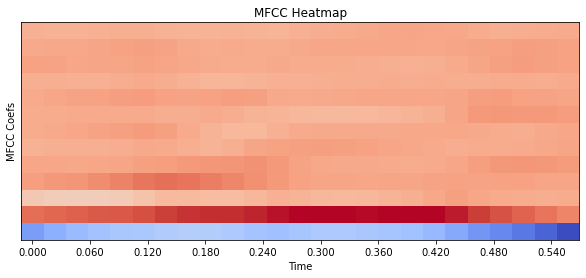

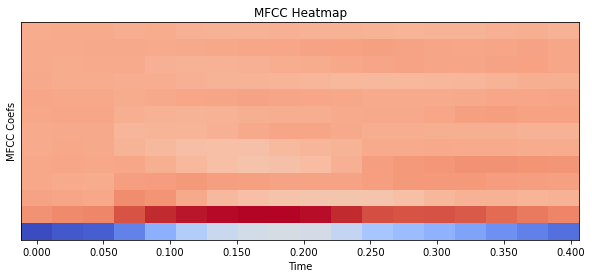

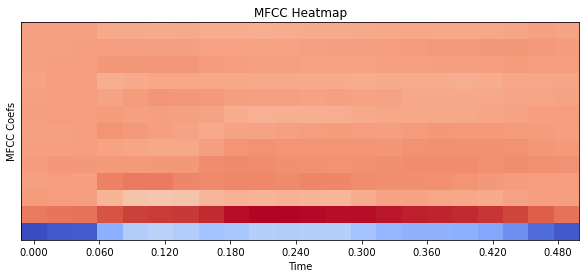

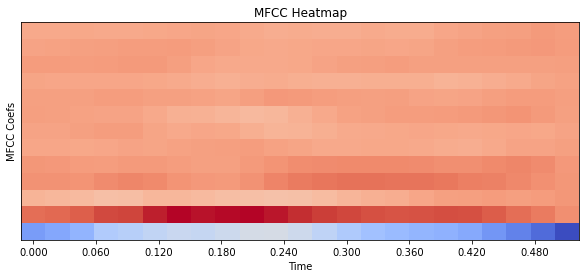

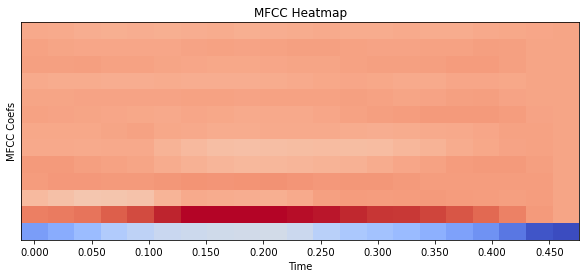

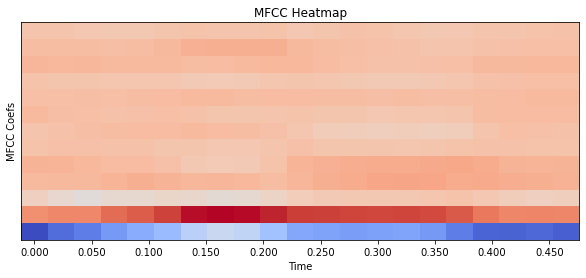

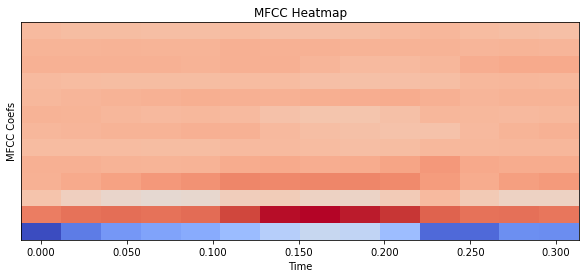

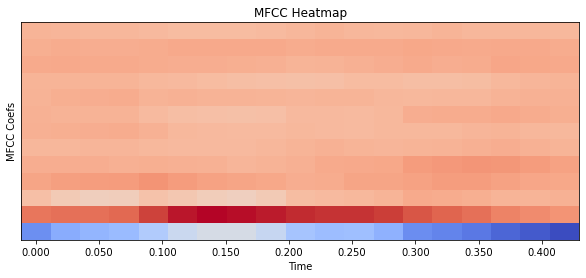

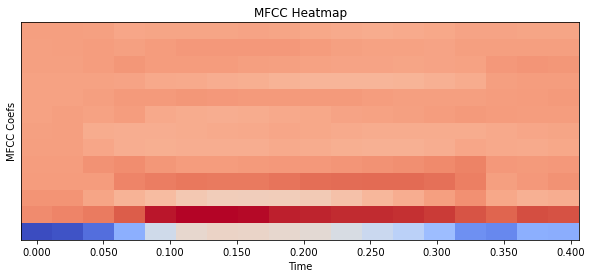

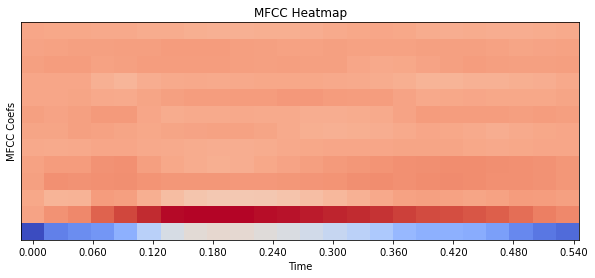

In [44]:
import os
audio_dir = "C:/Users/shima/Downloads/voices/cutrecordings"
for i in range(digit_numbers):
    filename = f"{i}_lucas_34.wav"
    file_path = os.path.join(audio_dir, filename)
    y, sr = librosa.load(file_path)
    coefs  = librosa.feature.mfcc(y=y, sr=sr,n_mfcc=13)
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(coefs, x_axis='time')
    plt.title('MFCC Heatmap')
    plt.ylabel('MFCC Coefs')
    plt.show()

In [45]:
audio_dir = "C:/Users/shima/Downloads/voices/cutrecordings"

# Initialize empty lists to store audio file paths and labels
audio_paths = []
labels = []

# Iterate through each file in the directory
for filename in os.listdir(audio_dir):
    if filename.endswith(".wav"):  # Check if the file is a WAV file
        # Extract label from filename
        parts = filename.split('_')
        label = int(parts[0])
        
        # Construct full file path
        file_path = os.path.join(audio_dir, filename)
        
        # Append audio file path and label
        audio_paths.append(file_path)
        labels.append(label)
            

In [46]:
len(labels[:300])

300

In [58]:
class HMM:
    def __init__(self, num_hidden_states):
        self.num_hidden_states = num_hidden_states
        self.rand_state = np.random.RandomState(1)

        self.initial_prob = self._normalize(self.rand_state.rand(self.num_hidden_states, 1))
        self.transition_matrix = self._stochasticize(self.rand_state.rand(self.num_hidden_states, self.num_hidden_states))

        self.mean = None
        self.covariances = None
        self.num_dimensions = None

    def _forward(self, observation_matrix):

        log_likelihood = 0.
        T = observation_matrix.shape[1]
        alpha = np.zeros(observation_matrix.shape)

        for t in range(T):
            if t == 0:
                alpha[:,0] = self.initial_prob[:,0] * observation_matrix[:,0]
            else:
                alpha[:,t] = np.matmul(self.transition_matrix.T,alpha[:,t-1]) * observation_matrix[:,t]
            alpha_sum = np.sum(alpha[:, t])
            alpha[:, t] /= alpha_sum
            log_likelihood += np.log(alpha_sum)

        return log_likelihood, alpha

    def _backward(self, observation_matrix):
        T = observation_matrix.shape[1]
        beta = np.zeros(observation_matrix.shape)

        beta[:, -1] = np.ones(observation_matrix.shape[0])

        for t in range(T - 1)[::-1]:
            beta[:, t] =  np.matmul(self.transition_matrix,(observation_matrix[:,t+1] * beta[:,t+1]))
            beta[:, t] /= np.sum(beta[:, t])

        return beta

    def _state_likelihood(self, obs):
       
        obs = np.atleast_2d(obs)
        B = np.zeros((self.num_hidden_states, obs.shape[1]))
        for s in range(self.num_hidden_states):
            np.random.seed(self.rand_state.randint(1))
            B[s, :] = multivariate_normal.pdf(obs.T,mean =self.mean[:,s],cov = self.covariances[:,:,s])

        return B

    def _normalize(self, x):
        return (x + (x == 0)) / np.sum(x)

    def _stochasticize(self, x):
        return (x + (x == 0)) / np.sum(x, axis=1)

    def _em_init(self, obs):
        if self.num_dimensions is None:
            self.num_dimensions = obs.shape[0]
        if self.mean is None:
            subset = self.rand_state.choice(np.arange(self.num_dimensions), size=self.num_hidden_states, replace=False)
            self.mean = obs[:, subset]
        if self.covariances is None:
            self.covariances = np.zeros((self.num_dimensions, self.num_dimensions, self.num_hidden_states))
            self.covariances += np.diag(np.diag(np.cov(obs)))[:, :, None]

        return self

    def _em_step(self, obs):
        obs = np.atleast_2d(obs)
        T = obs.shape[1]
        B = self._state_likelihood(obs)
        log_likelihood, alpha = self._forward(B)
        beta = self._backward(B)

        xi_sum = np.zeros((self.num_hidden_states, self.num_hidden_states))
        gamma = np.zeros((self.num_hidden_states, T))

        for t in range(T - 1):
            partial_sum = np.matmul(alpha[:,t],(beta[:,t+1].T*B[:,t+1].T))*self.transition_matrix
            xi_sum += self._normalize(partial_sum)
            partial_g = alpha[:,t] * beta[:,t]
            gamma[:, t] = self._normalize(partial_g)
        partial_g = alpha[:,T-1] * beta[:,T-1]
        gamma[:, -1] = self._normalize(partial_g)

        expected_prior = np.reshape(gamma[:, 0],(-1,1))
        expected_transition = self._stochasticize(xi_sum/np.sum(xi_sum,axis=(0,1)))

        expected_covariances = np.zeros((self.num_dimensions, self.num_dimensions, self.num_hidden_states))
        expected_covariances += .01 * np.eye(self.num_dimensions)[:, :, None]

        gamma_state_sum = np.sum(gamma, axis=1)
        gamma_state_sum = gamma_state_sum + (gamma_state_sum == 0)

        expected_mean = np.zeros((self.num_dimensions, self.num_hidden_states))
        for s in range(self.num_hidden_states):
            gamma_obs = obs * gamma[s, :]
            expected_mean[:, s] = np.sum(gamma_obs, axis=1) / gamma_state_sum[s]

        self.initial_prob = expected_prior
        self.mean = expected_mean
        self.covariances = expected_covariances
        self.transition_matrix = expected_transition

        return log_likelihood

    def train(self, obs, num_iterations=10):
        for i in range(num_iterations):
            self._em_init(obs)
            self._em_step(obs)
        return self

    def score(self, obs):
        B = self._state_likelihood(obs)
        log_likelihood, _ = self._forward(B)
        return log_likelihood

In [55]:
def hmm_train(min_audio_length=200):
    hmm_model_results = []
    test_list = []
    for i in range(10):
        x_train = np.array([])
        x_train_paths, x_test_paths, y_train_labels, y_test_labels = train_test_split(audio_paths[300*i:300*(i+1)], labels[300*i:300*(i+1)], test_size=0.25)
        for k in range(len(x_test_paths)):
            test_list.append((x_test_paths[k], y_test_labels[k]))

        for j in range(len(x_train_paths)):
            try:
                sampling_freq, audio = wavfile.read(x_train_paths[j])
                if audio.size == 0:
                    print(f"Skipping short or empty audio file: {x_train_paths[j]}")
                    continue
                # Pad the audio signal with zeros to make it at least min_audio_length long
                if len(audio) < min_audio_length:
                    audio = np.pad(audio, (0, min_audio_length - len(audio)), 'constant')
                coefs = mfcc(audio, sampling_freq, nfft=1024)
                if j == 0:
                    x_train = coefs[:min_len, :]
                else:
                    x_train = np.append(x_train, coefs[:min_len, :], axis=0)
            except Exception as e:
                print(f"Error processing file {x_train_paths[j]}: {e}")
                
        if x_train.size == 0:
            print(f"No valid data for training: {x_train_paths}")
            continue
                
        model = HMM(10)
        model.train(x_train.T/np.amax(x_train.T),2)
        hmm_model_results.append(model)

    return hmm_model_results, test_list

hmm_model_results, test_list = hmm_train()


Skipping short or empty audio file: C:/Users/shima/Downloads/voices/cutrecordings\0_theo_2.wav
Skipping short or empty audio file: C:/Users/shima/Downloads/voices/cutrecordings\0_theo_5.wav
Skipping short or empty audio file: C:/Users/shima/Downloads/voices/cutrecordings\0_theo_13.wav
Skipping short or empty audio file: C:/Users/shima/Downloads/voices/cutrecordings\0_theo_9.wav
Skipping short or empty audio file: C:/Users/shima/Downloads/voices/cutrecordings\0_theo_27.wav
Skipping short or empty audio file: C:/Users/shima/Downloads/voices/cutrecordings\0_theo_18.wav
Skipping short or empty audio file: C:/Users/shima/Downloads/voices/cutrecordings\0_theo_46.wav
Skipping short or empty audio file: C:/Users/shima/Downloads/voices/cutrecordings\0_theo_40.wav
Skipping short or empty audio file: C:/Users/shima/Downloads/voices/cutrecordings\0_theo_0.wav
Skipping short or empty audio file: C:/Users/shima/Downloads/voices/cutrecordings\0_theo_17.wav
Skipping short or empty audio file: C:/Users

Skipping short or empty audio file: C:/Users/shima/Downloads/voices/cutrecordings\4_theo_37.wav
Skipping short or empty audio file: C:/Users/shima/Downloads/voices/cutrecordings\4_theo_38.wav
Skipping short or empty audio file: C:/Users/shima/Downloads/voices/cutrecordings\4_theo_10.wav
Skipping short or empty audio file: C:/Users/shima/Downloads/voices/cutrecordings\4_theo_48.wav
Skipping short or empty audio file: C:/Users/shima/Downloads/voices/cutrecordings\4_theo_47.wav
Skipping short or empty audio file: C:/Users/shima/Downloads/voices/cutrecordings\4_theo_19.wav
Skipping short or empty audio file: C:/Users/shima/Downloads/voices/cutrecordings\5_theo_21.wav
Skipping short or empty audio file: C:/Users/shima/Downloads/voices/cutrecordings\5_theo_43.wav
Skipping short or empty audio file: C:/Users/shima/Downloads/voices/cutrecordings\5_theo_33.wav
Skipping short or empty audio file: C:/Users/shima/Downloads/voices/cutrecordings\5_theo_5.wav
Skipping short or empty audio file: C:/Us

Skipping short or empty audio file: C:/Users/shima/Downloads/voices/cutrecordings\9_theo_10.wav
Skipping short or empty audio file: C:/Users/shima/Downloads/voices/cutrecordings\9_yweweler_32.wav
Skipping short or empty audio file: C:/Users/shima/Downloads/voices/cutrecordings\9_theo_48.wav
Skipping short or empty audio file: C:/Users/shima/Downloads/voices/cutrecordings\9_theo_19.wav


In [56]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

def evaluate(hmm_model_results, test_list, mode):
    counter = 0
    test_size = 0
    predicted_labels = []
    true_labels = []
    min_audio_length = 200

    for i in range(len(test_list)):
        path, label = test_list[i]
        sampling_freq, audio = wavfile.read(path)
        if audio.size == 0:
            print(f"Skipping short or empty audio file: {path}")
            continue
        # Pad the audio signal with zeros to make it at least min_audio_length long
        if len(audio) < min_audio_length:
            audio = np.pad(audio, (0, min_audio_length - len(audio)), 'constant')
        coefs = mfcc(audio, sampling_freq, nfft=1024)
        
        model_prob = []
        for j in range(digit_numbers):
            
            if mode == "library hmm":
                prob = hmm_model_results[j].score(coefs)
            else:
                prob = hmm_model_results[j].score(coefs.T / np.amax(coefs.T))
            model_prob.append(prob)
        
        test_size += 1
        predicted_label = digits[argmax(model_prob)]
        predicted_labels.append(int(predicted_label))
        true_labels.append(int(label))

        if int(predicted_label) == int(label):
            counter += 1
    print(counter, test_size)
    accuracy = counter / test_size
    precision = precision_score(true_labels, predicted_labels, average='macro')
    recall = recall_score(true_labels, predicted_labels, average='macro')
    f1 = f1_score(true_labels, predicted_labels, average='macro')
    conf_matrix = confusion_matrix(true_labels, predicted_labels)
    
    return accuracy, precision, recall, f1, conf_matrix


In [57]:
accuracy, precision, recall, f1, conf_matrix = evaluate(hmm_model_results, test_list, "my hmm")

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Confusion Matrix:")
print(conf_matrix)

Skipping short or empty audio file: C:/Users/shima/Downloads/voices/cutrecordings\0_theo_16.wav
Skipping short or empty audio file: C:/Users/shima/Downloads/voices/cutrecordings\0_theo_28.wav
Skipping short or empty audio file: C:/Users/shima/Downloads/voices/cutrecordings\0_theo_44.wav
Skipping short or empty audio file: C:/Users/shima/Downloads/voices/cutrecordings\0_theo_36.wav
Skipping short or empty audio file: C:/Users/shima/Downloads/voices/cutrecordings\0_theo_14.wav
Skipping short or empty audio file: C:/Users/shima/Downloads/voices/cutrecordings\0_theo_8.wav
Skipping short or empty audio file: C:/Users/shima/Downloads/voices/cutrecordings\0_theo_35.wav
Skipping short or empty audio file: C:/Users/shima/Downloads/voices/cutrecordings\0_theo_4.wav
Skipping short or empty audio file: C:/Users/shima/Downloads/voices/cutrecordings\0_theo_26.wav
Skipping short or empty audio file: C:/Users/shima/Downloads/voices/cutrecordings\0_theo_3.wav
Skipping short or empty audio file: C:/User

Skipping short or empty audio file: C:/Users/shima/Downloads/voices/cutrecordings\9_theo_35.wav
Skipping short or empty audio file: C:/Users/shima/Downloads/voices/cutrecordings\9_theo_4.wav
Skipping short or empty audio file: C:/Users/shima/Downloads/voices/cutrecordings\9_yweweler_9.wav
Skipping short or empty audio file: C:/Users/shima/Downloads/voices/cutrecordings\9_theo_3.wav
Skipping short or empty audio file: C:/Users/shima/Downloads/voices/cutrecordings\9_theo_41.wav
Skipping short or empty audio file: C:/Users/shima/Downloads/voices/cutrecordings\9_theo_20.wav
Skipping short or empty audio file: C:/Users/shima/Downloads/voices/cutrecordings\9_theo_34.wav
497 655
Accuracy: 0.7587786259541984
Precision: 0.800412034645387
Recall: 0.7549453286935498
F1 Score: 0.7410890449982314
Confusion Matrix:
[[55  1  2  0  2  0  1  1  0  0]
 [ 0 65  0  0  2  0  0  1  0  0]
 [ 3  1 61  3  0  0  1  1  0  0]
 [11  0  4 27  0  0 20  3  1  0]
 [ 0 21  0  0 42  1  0  0  0  0]
 [ 5  5  0  0  0 51  1

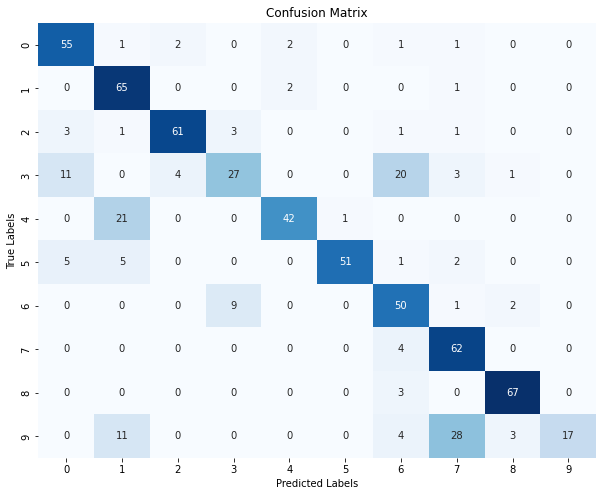

In [54]:
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

In [64]:
# Calculate precision, recall, and F1-score
num_classes = len(conf_matrix)
precision = np.zeros(num_classes)
recall = np.zeros(num_classes)
f1_score = np.zeros(num_classes)

for i in range(num_classes):
    true_positive = conf_matrix[i, i]
    false_positive = np.sum(conf_matrix[:, i]) - true_positive
    false_negative = np.sum(conf_matrix[i, :]) - true_positive
    
    # Calculate precision
    precision[i] = true_positive / (true_positive + false_positive) if (true_positive + false_positive) != 0 else 0
    
    # Calculate recall
    recall[i] = true_positive / (true_positive + false_negative) if (true_positive + false_negative) != 0 else 0
    
    # Calculate F1-score
    f1_score[i] = 2 * (precision[i] * recall[i]) / (precision[i] + recall[i]) if (precision[i] + recall[i]) != 0 else 0

# Compute average precision, recall, and F1-score
average_precision = np.mean(precision)
average_recall = np.mean(recall)
average_f1_score = np.mean(f1_score)

print("Average Precision:", average_precision)
print("Average Recall:", average_recall)
print("Average F1-score:", average_f1_score)


# Display the table
print("Class\tPrecision\tRecall\tF1-score")
for i in range(num_classes):
    print(f"{i}\t{precision[i]:.4f}\t\t{recall[i]:.4f}\t{f1_score[i]:.4f}")

Average Precision: 0.800412034645387
Average Recall: 0.7549453286935498
Average F1-score: 0.7410890449982314
Class	Precision	Recall	F1-score
0	0.7432		0.8871	0.8088
1	0.6250		0.9559	0.7558
2	0.9104		0.8714	0.8905
3	0.6923		0.4091	0.5143
4	0.9130		0.6562	0.7636
5	0.9808		0.7969	0.8793
6	0.5952		0.8065	0.6849
7	0.6263		0.9394	0.7515
8	0.9178		0.9571	0.9371
9	1.0000		0.2698	0.4250


In [95]:
names = ["george", "jackson", "lucas", "nicolas", "yweweler"]

In [104]:
labels = [[], [], [], [], [], []]

# Iterate through each file in the directory
audio_paths = [[], [], [], [], [], []]
for filename in os.listdir(audio_dir):
    if filename.endswith(".wav"):  # Check if the file is a WAV file
        # Extract label from filename
        parts = filename.split('_')
        label = parts[1]
        # Construct full file path
        if label == "theo":
            continue
        file_path = os.path.join(audio_dir, filename)
        
        # Append audio file path and label
        audio_paths[int(names.index(label))].append(file_path)
        labels[int(names.index(label))].append(label)

In [105]:
labels.count("jackson")

0

In [106]:
print(len(audio_paths[3]))

500


In [107]:
def hmm_train(min_audio_length=200):
    hmm_model_results = []
    test_list = []
    for i in range(5):
        x_train = np.array([])
        x_train_paths, x_test_paths, y_train_labels, y_test_labels = train_test_split(audio_paths[i], labels[i], test_size=0.25)
        for k in range(len(x_test_paths)):
            test_list.append((x_test_paths[k], y_test_labels[k]))
            if k == 0:
                print(x_test_paths[k], y_test_labels[k])

        for j in range(len(x_train_paths)):
            try:
                sampling_freq, audio = wavfile.read(x_train_paths[j])
                if audio.size == 0:
                    print(f"Skipping short or empty audio file: {x_train_paths[j]}")
                    continue
                # Pad the audio signal with zeros to make it at least min_audio_length long
                if len(audio) < min_audio_length:
                    audio = np.pad(audio, (0, min_audio_length - len(audio)), 'constant')
                coefs = mfcc(audio, sampling_freq, nfft=1024)
                if j == 0:
                    x_train = coefs[:min_len, :]
                else:
                    x_train = np.append(x_train, coefs[:min_len, :], axis=0)
            except Exception as e:
                print(f"Error processing file {x_train_paths[j]}: {e}")
                
        if x_train.size == 0:
            print(f"No valid data for training: {x_train_paths}")
            continue
                
        model = HMM(5)
        model.train(x_train.T/np.amax(x_train.T),2)
        hmm_model_results.append(model)

    return hmm_model_results, test_list

hmm_model_results, test_list = hmm_train()


C:/Users/shima/Downloads/voices/cutrecordings\1_george_45.wav george
C:/Users/shima/Downloads/voices/cutrecordings\1_jackson_45.wav jackson
C:/Users/shima/Downloads/voices/cutrecordings\1_lucas_45.wav lucas
C:/Users/shima/Downloads/voices/cutrecordings\1_nicolas_45.wav nicolas
C:/Users/shima/Downloads/voices/cutrecordings\1_yweweler_45.wav yweweler
Skipping short or empty audio file: C:/Users/shima/Downloads/voices/cutrecordings\9_yweweler_15.wav
Skipping short or empty audio file: C:/Users/shima/Downloads/voices/cutrecordings\6_yweweler_37.wav
Skipping short or empty audio file: C:/Users/shima/Downloads/voices/cutrecordings\1_yweweler_37.wav
Skipping short or empty audio file: C:/Users/shima/Downloads/voices/cutrecordings\9_yweweler_9.wav
Skipping short or empty audio file: C:/Users/shima/Downloads/voices/cutrecordings\9_yweweler_35.wav
Skipping short or empty audio file: C:/Users/shima/Downloads/voices/cutrecordings\9_yweweler_32.wav
Skipping short or empty audio file: C:/Users/shima

In [128]:
def evaluate(hmm_model_results, test_list, mode):
    counter = 0
    test_size = 0
    predicted_labels = []
    true_labels = []
    min_audio_length = 200

    for i in range(len(test_list)):
        path, label = test_list[i]
        sampling_freq, audio = wavfile.read(path)
        if audio.size == 0:
            print(f"Skipping short or empty audio file: {path}")
            continue
        # Pad the audio signal with zeros to make it at least min_audio_length long
        if len(audio) < min_audio_length:
            audio = np.pad(audio, (0, min_audio_length - len(audio)), 'constant')
        coefs = mfcc(audio, sampling_freq, nfft=1024)
        
        model_prob = []
        for j in range(len(names)):
            
            if mode == "library hmm":
                prob = hmm_model_results[j].score(coefs)
            else:
                prob = hmm_model_results[j].score(coefs.T / np.amax(coefs.T))
            model_prob.append(prob)
        
        test_size += 1
        predicted_label = names[argmax(model_prob)]
        predicted_labels.append(str(predicted_label))
        true_labels.append(str(label))
#         print(type(true_labels))
#         print(type(predicted_labels))

        if predicted_label == label:
            counter += 1
    print(counter, test_size)
    accuracy = counter / test_size
    print(f"accuracy is : {accuracy}")
    conf_matrix = confusion_matrix(true_labels, predicted_labels)
    
    return conf_matrix


In [129]:
conf_matrix = evaluate(hmm_model_results, test_list, "my hmm")

# Calculate precision, recall, and F1-score
num_classes = len(conf_matrix)
precision = np.zeros(num_classes)
recall = np.zeros(num_classes)
f1_score = np.zeros(num_classes)

for i in range(num_classes):
    true_positive = conf_matrix[i, i]
    false_positive = np.sum(conf_matrix[:, i]) - true_positive
    false_negative = np.sum(conf_matrix[i, :]) - true_positive
    
    # Calculate precision
    precision[i] = true_positive / (true_positive + false_positive) if (true_positive + false_positive) != 0 else 0
    
    # Calculate recall
    recall[i] = true_positive / (true_positive + false_negative) if (true_positive + false_negative) != 0 else 0
    
    # Calculate F1-score
    f1_score[i] = 2 * (precision[i] * recall[i]) / (precision[i] + recall[i]) if (precision[i] + recall[i]) != 0 else 0

# Compute average precision, recall, and F1-score
average_precision = np.mean(precision)
average_recall = np.mean(recall)
average_f1_score = np.mean(f1_score)

print("Average Precision:", average_precision)
print("Average Recall:", average_recall)
print("Average F1-score:", average_f1_score)


# Display the table
print("Class\tPrecision\tRecall\tF1-score")
for i in range(num_classes):
    print(f"{i}\t{precision[i]:.4f}\t\t{recall[i]:.4f}\t{f1_score[i]:.4f}")

Skipping short or empty audio file: C:/Users/shima/Downloads/voices/cutrecordings\2_yweweler_25.wav
Skipping short or empty audio file: C:/Users/shima/Downloads/voices/cutrecordings\9_yweweler_31.wav
Skipping short or empty audio file: C:/Users/shima/Downloads/voices/cutrecordings\6_yweweler_36.wav
440 622
accuracy is : 0.707395498392283
Average Precision: 0.7859301719645649
Average Recall: 0.7067147540983607
Average F1-score: 0.6863708972787101
Class	Precision	Recall	F1-score
0	0.5895		0.8960	0.7111
1	1.0000		0.2800	0.4375
2	1.0000		0.8000	0.8889
3	0.6139		0.9920	0.7584
4	0.7263		0.5656	0.6359


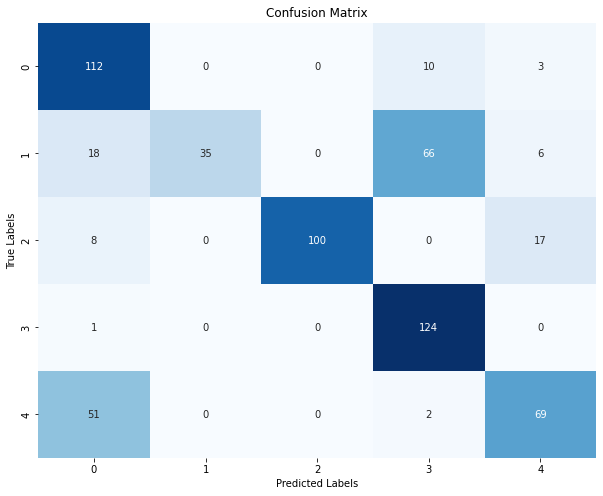

In [130]:
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()